In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import whynot as wn
import pandas as pd
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Regression Discontinuity Design
In this notebook, we explore how one might perform an experiment and analyze the data collected using regression discontinuity design (RDD). Typically an RDD is applied when the assignment of treatment $T$ is determined by whether an observed covariate $X$ lies on one side of a fixed threshold value $c$. Under the assumption that the outcome variable $Y$ varies continuously with $X$ for treated (or untreated) individuals, one can estimate the treatment effect $\mathbb{E}[Y \mid do(T=1)] - \mathbb{E}[Y \mid do(T=0)]$ by performing regressions on both sides of the threshold.

## Simulation: World2
We use the World2 simulator. In this experiment, we set up the following: $X$ is the initial population level (Year 1900), $Y$ is the population at the end of the simulation (Year 2000), and the treatment is lowering the pollution factor from 1 to 0.75 in Year 1901. The threshold for assigning treatment is $c = 2e8$. In other words, the pollution factor is lowered $(T=1)$ if and only if the initial pollution level is higher than $c$.

Running the following commands shows us the default values of the simulator parameters.

In [2]:
wn.world2.State()

State(population=1650000000.0, natural_resources=900000000000.0, capital_investment=400000000.0, pollution=200000000.0, capital_investment_in_agriculture=0.2, quality_of_life=1.0)

In [3]:
wn.world2.Config()

Config(birth_rate=0.04, death_rate=0.028, effective_capital_investment_ratio=1.0, natural_resources_usage=1.0, land_area=135000000.0, population_density=26.5, food_coefficient=1.0, food_normal=1.0, capital_investment_agriculture=0.3, capital_investment_generation=0.05, capital_investment_discard=0.025, pollution_standard=3600000000.0, pollution=1.0, intervention_time=1970, capital_investment_in_agriculture_frac_adj_time=15.0, quality_of_life_standard=1.0, start_time=1900, end_time=2100, delta_t=0.2)

In [5]:
from whynot.framework import DynamicsExperiment, parameter
from whynot.simulators import world2

def sample_initial_states(rng):
    """Sample an initial world2 state by perturbing the default."""
    state = world2.State()
    state.population *= rng.uniform(0.75, 2)
    state.natural_resources *= rng.uniform(0.25, 10.)
    state.capital_investment *= rng.uniform(0.5, 2.0)
    state.pollution *= rng.uniform(0.2, 2.)
    state.capital_investment_in_agriculture *= rng.uniform(0.5, 1.5)
    return state


###########################
# Threshold Treatment Experiment
###########################
@parameter(name="treatment_threshold", default=200000000.0, description="Threshold for treatment")
def threshold_treatment_propensity(run, treatment_threshold):
    """Compute propensity scores as a function of the bias."""
    
    # assign treatment with prob 1 if initial pollution is above threshold, prob 0 otherwise
    if run.initial_state.pollution >= treatment_threshold:
        return 1.0
    return 0.


ThresholdTreatment = DynamicsExperiment(
    name="world2_threshold_treatment",
    description="Experiment with threshold treatment on World 2.",
    simulator=world2,
    simulator_config=world2.Config(end_time=2000),
    intervention=world2.Intervention(time=1901, pollution=0.75),  
    state_sampler=sample_initial_states,
    propensity_scorer=threshold_treatment_propensity,
    outcome_extractor=lambda run: run[2000].population, 
    covariate_builder=lambda run: run.initial_state.pollution)

Now we instantiate the experiment and collect 1000 independent samples.

In [6]:
tt = ThresholdTreatment
tt.description

'Experiment with threshold treatment on World 2.'

In [7]:
dset = tt.run(num_samples=1000, show_progress=True, seed=1234)

In [8]:
(X, W, Y) = dset.covariates, dset.treatments, dset.outcomes

For convenience we scale down the values for population and pollution.

In [9]:
scaling = 1. / 1e8
data = pd.DataFrame({'y':Y*scaling, 'x': X.flatten()*scaling})
threshold = 2e8 * scaling

Let's take a look at the data. Visually, the population numbers are higher to the left of the threshold $c$.

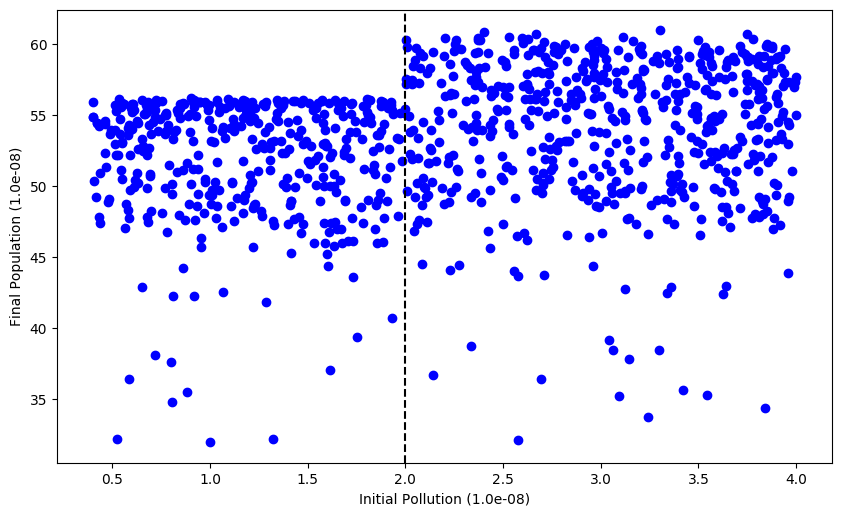

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(data.x, data.y, color="blue")
plt.xlabel("Initial Pollution (%.1e)"%scaling)
plt.ylabel("Final Population (%.1e)"%scaling)
plt.axvline(x=threshold, color="black", linestyle="--")
plt.show()
plt.close()

The bandwidth of the RDD is a window around the threshold $c$. We use only the data points inside the window and ignore data points beyond it. We can pick the optimal bandwidth, in this case, using the Imbens-Kalyanamaran optimal bandwidth calculation.

In [ ]:
!pip install rdd
from rdd import rdd

In [12]:
bandwidth_opt = rdd.optimal_bandwidth(data['y'], data['x'], cut=threshold)
print("Optimal bandwidth:", bandwidth_opt)

Optimal bandwidth: 0.8701359176102788


## Set up the Regression
Now, we perform the regression discontinuity analysis. First, we set up the dataframe by creating two new columns: one for the treatment variable $T$ and one for the centered covariate $X$.

In [13]:
def treat(x, threshold):
    if(x>=threshold):
        return 1
    return 0

data['treat'] = data['x'].map(lambda x: treat(x,threshold))
data['x_centered'] = data['x'].map(lambda x: x-threshold)

We regress $Y$ on $X$ and $T$ by ordinary least squares. We can make two observations: $T$ has a statistically significant effect on $Y$ (there is a positive jump discontinuity at the threshold), and $Y$ decreases with $X$. Both observations corroborate with our intuition about how the World2 model should behave. Lowering the pollution factor increases the future pollution, and higher initial pollution levels decreases the futture pollution.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     16.47
Date:                Sun, 03 Nov 2019   Prob (F-statistic):           1.25e-07
Time:                        20:47:38   Log-Likelihood:                -1304.1
No. Observations:                 450   AIC:                             2614.
Df Residuals:                     447   BIC:                             2627.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     52.3061      0.475    110.042      0.0

Text(0, 0.5, 'Final Population (1.0e-08)')

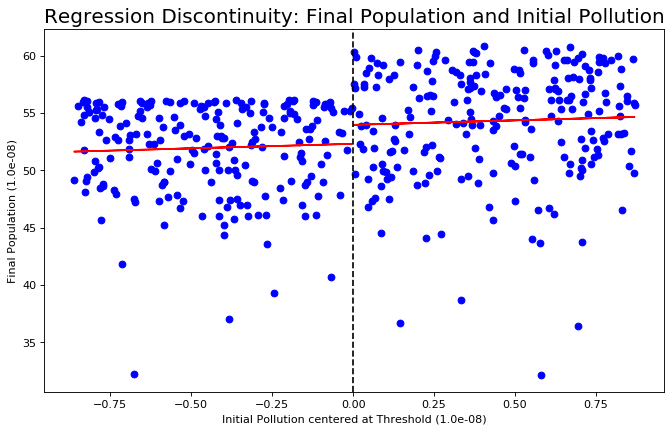

In [14]:
data_cut = data[(data['x_centered']>=-bandwidth_opt) & (data['x_centered']<=bandwidth_opt)]
result = smf.ols(formula = "y ~ x_centered + treat", data = data_cut).fit()
print(result.summary())

plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(data_cut.x_centered, data_cut.y, color="blue")
plt.plot(data_cut.x_centered[data_cut.x_centered<0], result.predict()[data_cut.x_centered<0], '-', color="r")
plt.plot(data_cut.x_centered[data_cut.x_centered>=0], result.predict()[data_cut.x_centered>=0], '-', color="r")
plt.axvline(x=0,color="black", linestyle="--")
plt.title("Regression Discontinuity: Final Population and Initial Pollution", fontsize="18")
plt.xlabel("Initial Pollution centered at Threshold (%.1e)"%scaling)
plt.ylabel("Final Population (%.1e)"%scaling)